In [79]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [86]:
import os
import numpy as np
import cv2
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, InputLayer, Lambda
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [81]:
# from google.colab import drive
# drive.mount('/content/drive/')


## Data Reading

In [82]:
# Read inputs and images
images = []
labels = []
dataset = 'vehicle_dataset'

for folder in os.listdir(dataset):
    if not folder.startswith('.'):
        label = None

        if folder in ['vehicles']: label = 0
        elif folder in ['non-vehicles']: label = 1

        for file in os.listdir(os.path.join(dataset, folder)):
            if file.endswith('.png'):
                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)

                images.append(image)
                labels.append(label)

images = np.array(images, dtype='float32')/255.0
labels = np.array(labels, dtype='int32')

images = images.reshape(-1,64,64,3)

images, labels = shuffle(images, labels, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [83]:
images[0].shape

(64, 64, 3)

## Data Preprocessing

In [85]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(X_train)
datagen.fit(X_test)
datagen.fit(X_val)

## Model Defining

In [84]:
# Model definition
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(64,64,3)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))
 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val, y_val)) 

Epoch 1/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 109s 325ms/step - accuracy: 0.8680 - loss: 0.3128 - val_accuracy: 0.9690 - val_loss: 0.0883
Epoch 2/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 92s 275ms/step - accuracy: 0.9792 - loss: 0.0672 - val_accuracy: 0.9741 - val_loss: 0.0784
Epoch 3/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 98s 293ms/step - accuracy: 0.9856 - loss: 0.0479 - val_accuracy: 0.9854 - val_loss: 0.0397
Epoch 4/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 95s 286ms/step - accuracy: 0.9797 - loss: 0.0606 - val_accuracy: 0.9806 - val_loss: 0.0551
Epoch 5/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 99s 298ms/step - accuracy: 0.9833 - loss: 0.0515 - val_accuracy: 0.9893 - val_loss: 0.0285


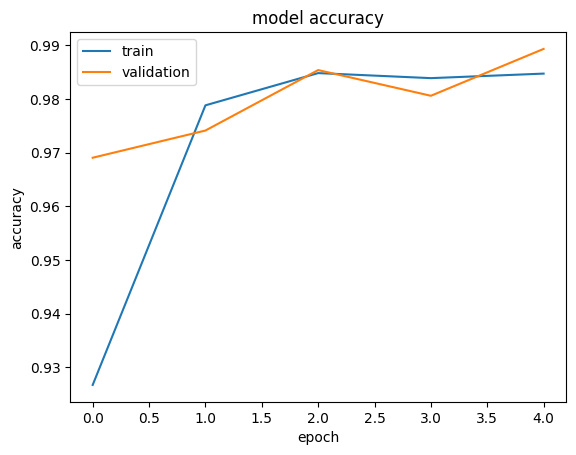

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()

In [90]:
loss, accuracy = model.evaluate(X_test, y_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9846 - loss: 0.0542


In [91]:
# Test the model
y_pred = model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step


In [92]:
accuracy = accuracy_score(y_test, y_pred > 0.5)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.985


## Pretrained Models

*VGG16 using ImageNet weights*

In [100]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

new_xtrain = preprocess_input(X_train)
new_val = preprocess_input(X_val)

# Freeze the VGG16 layers
for layer in vgg_base.layers:
    layer.trainable = False

# # Add a classifier on top
vgg_model = Sequential()
vgg_model.add(vgg_base)
vgg_model.add(tf.keras.layers.Flatten())
vgg_model.add(tf.keras.layers.Dropout(0.5))
vgg_model.add(tf.keras.layers.Dense(50, activation='relu'))
vgg_model.add(tf.keras.layers.Dropout(0.5))
vgg_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
vgg_model.summary()

vgg_model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

# Train the model

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()

In [97]:
y_pred = vgg_model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step


In [98]:
accuracy = accuracy_score(y_test, y_pred > 0.5)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.472


*ResNet50*

In [101]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=[64,64, 3])

pretrained_model = Sequential()
pretrained_model.add(InputLayer(input_shape=(64, 64, 3)))
pretrained_model.add(baseModel)
pretrained_model.add(Flatten())
pretrained_model.add(tf.keras.layers.Dropout(0.5))
pretrained_model.add(tf.keras.layers.Dense(50, activation='relu'))
pretrained_model.add(tf.keras.layers.Dropout(0.5))
pretrained_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
pretrained_model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 50)             │       409,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,997,413 (91.54 MB)

 Trainable params: 23,944,293 (91.34 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [102]:
pretrained_pred = pretrained_model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step


In [103]:
pretrained_pred_binary = (pretrained_pred > 0.5).astype(int)
pretrained_accuracy = accuracy_score(y_test, pretrained_pred_binary)
print(f'Accuracy: {pretrained_accuracy:.3f}')


Accuracy: 0.477
